In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('ggplot')

In [2]:
# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [3]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

In [4]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

## Data Import & notebook preperation


In [23]:
data = pd.read_csv('datasets/TMDB/train.csv')
y = data ['revenue']
x = data .drop(['revenue'], axis = 1)
test_data = pd.read_csv('datasets/TMDB/test.csv')
data_backup = data.copy()

## EDA

### Overview

There are 3000 train data in total

In [24]:
x.shape

(3000, 22)

In [25]:
x.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

In [26]:
test_data.shape

(4398, 22)

In [27]:
test_data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

In [28]:
x.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


The following columns have a lot missing values:

**1.** belongs_to_collection 
<br>
**2.** homepage

I'll considering to make binary categorical variables for them.
<br>
The rest columns all only miss a small percentage so we can probabaly impute for missing values.

In [29]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 22 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

**the basic description of columns**

**Data Description id** - Integer unique id of each movie

**belongs_to_collection** - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

**budget** - Budget of a movie in dollars. 0 values mean unknown.

**genres** - Contains all the Genres Name & TMDB Id in JSON Format

**homepage** - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/ , this is the homepage of Whiplash movie.

**imdb_id** - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/

**original_language** - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.

**original_title** - The original title of a movie. Title & Original title may differ, if the original title is not in English.

**overview** - Brief description of the movie.

**popularity** - Popularity of the movie in float.

**poster_path** - Poster path of a movie. You can see the full image like this: https://image.tmdb.org/t/p/original/

**production_companies** - All production company name and TMDB id in JSON format of a movie.

**production_countries** - Two digit code and full name of the production company in JSON format.

**release_date** - Release date of a movie in mm/dd/yy format.

**runtime** - Total runtime of a movie in minutes (Integer).

**spoken_languages** - Two digit code and full name of the spoken language.

**status** - Is the movie released or rumored?

**tagline** - Tagline of a movie

**title** - English title of a movie

**Keywords** - TMDB Id and name of all the keywords in JSON format.

**cast** - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

**crew** - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

**revenue** - Total revenue earned by a movie in dollars.

In [30]:
x.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,321,2398,NaN,401,2,2400,2969,2648,2975,2984
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0093507,en,The Magnificent Seven,Zohre's shoes are gone; her older brother Ali ...,NaN,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Bad Boys,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '52fe461a9251416c910493c7', 'de..."
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,1752,5,NaN,1817,2996,3,2,27,13,1
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


explore the relationship between the target variable and the numerical variables. It appears that all 3 numerical variables are correlated strongly to the target.

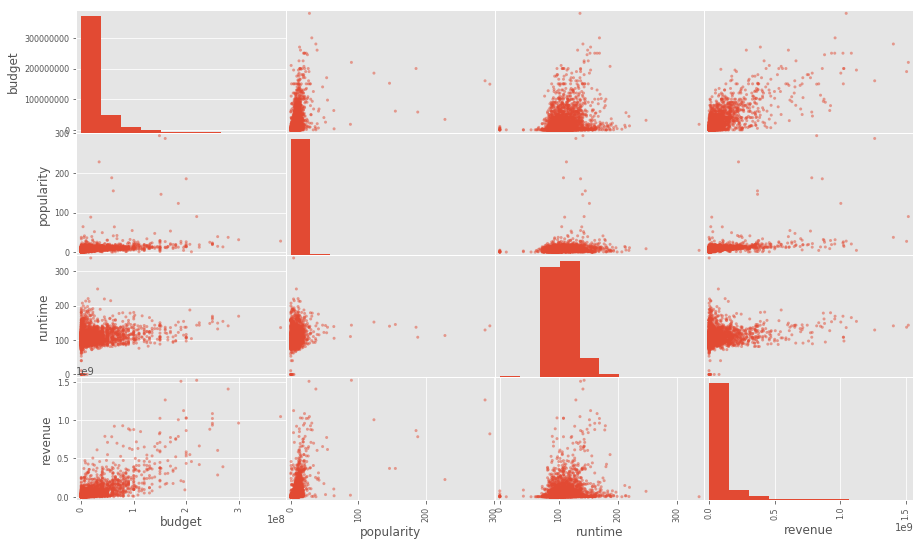

In [31]:
from pandas.plotting import scatter_matrix

attributes_num = ["budget", "popularity", "runtime", "revenue"]

scatter_matrix(data[attributes_num], figsize=(15, 9));

The revenue is highly skewed to the right so we take log(1+y).

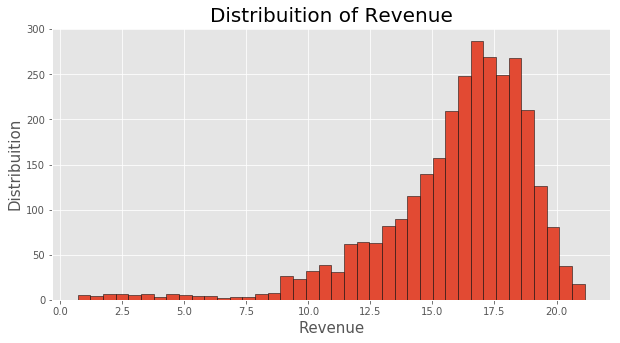

In [32]:
plt.figure(figsize=(10,5))

plt.hist(np.log1p(y), bins=40, edgecolor='black')
plt.xlabel('Revenue', fontsize=15) #seting the xlabel and size of font
plt.ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
plt.title("Distribuition of Revenue", fontsize=20) #seting the title and size of font
plt.show()

## Feature Engineering
<br>
I got some great ideas from the following Kaggle kernel: https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat

### belongs_to_collection

In [33]:
import ast

for i, e in enumerate(x['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 nan
3 nan
4 nan


Since there are too many missing values, I will create a new boolean feature 'belongs_to_collection_cat' to indicate if a record belongs to a collection or not

In [34]:
def booleanize(data, column_name):
    data[column_name] = data[column_name].fillna('[{}]')

    boolean_array = []

    for index, row in data[column_name].iteritems():
        belongs_to = 0
        listofDict = ast.literal_eval(row)
        for dic in listofDict:       
            if('name' in dic.keys()):
                belongs_to = 1
        boolean_array.append(belongs_to)
    
    return boolean_array
       
x['belongs_to_collection_cat'] = booleanize(x, 'belongs_to_collection')
test_data['belongs_to_collection_cat'] = booleanize(test_data, 'belongs_to_collection')

### genres

In [35]:
for i, e in enumerate(x['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


factorize the genres

In [36]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

x['genres'] = x['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = x.genres.str.get_dummies(sep=',')
x = pd.concat([x, genres], axis=1)

In [37]:
x.head().iloc[:, -20:]

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [38]:
test_data['genres'] = test_data['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = test_data.genres.str.get_dummies(sep=',')
test_data = pd.concat([test_data, genres], axis=1)

### homepage 

In [39]:
for i, e in enumerate(x['homepage'][:10]):
    print(i, e)
    print(type(e) is str)

0 nan
False
1 nan
False
2 http://sonyclassics.com/whiplash/
True
3 http://kahaanithefilm.com/
True
4 nan
False
5 nan
False
6 http://www.thepossessionmovie.com/
True
7 nan
False
8 nan
False
9 nan
False


Same strategy as 'belongs_to_collection'

In [40]:
x['homepage_cat'] = x['homepage'].apply(lambda x: 1 if type(x) is str else 0)
test_data['homepage_cat'] = test_data['homepage'].apply(lambda x: 1 if type(x) is str else 0)

In [41]:
x.homepage_cat.head()

0    0
1    0
2    1
3    1
4    0
Name: homepage_cat, dtype: int64

### original_language

take a look at frequency - the super majority is English. So make a boolean feature 'is_origLang_English' to indicate if the original language is English or not.

In [42]:
x.original_language.value_counts()

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
nl       6
pt       6
da       5
fa       5
ro       4
hu       3
tr       3
ml       2
pl       2
no       2
fi       2
te       2
mr       1
vi       1
sr       1
ur       1
id       1
el       1
bn       1
cs       1
he       1
nb       1
ar       1
Name: original_language, dtype: int64

In [43]:
x['is_origLang_English'] = 1
x.loc[x['original_language'] != 'en', 'is_origLang_English'] = 0

In [44]:
test_data['is_origLang_English'] = 1
test_data.loc[test_data['original_language'] != 'en', 'is_origLang_English'] = 0

### original_title and title

In [45]:
x.original_title.head()

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                        마린보이
Name: original_title, dtype: object

creat a new feature 'is_title_different' to indicate if the original title is different from the English title

In [46]:
x['is_title_different'] = (x['original_title'] == x['title']).astype(int)
test_data['is_title_different'] = (test_data['original_title'] == test_data['title']).astype(int)

### production_companies

In [47]:
for i, e in enumerate(x['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 nan
4 nan


In [48]:
x['production_companies'] = x['production_companies'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
production_companies = x.production_companies.str.get_dummies(sep=',')
x = pd.concat([x, production_companies], axis=1)

There are 3698 different production companies! Many of them only has movies, so we will bin the ones with low production together to 'other' category.

In [49]:
x.iloc[:, -3698:].sum(axis=0).sort_values(ascending=False).head(26)

Warner Bros.                              202
Universal Pictures                        188
Paramount Pictures                        161
Twentieth Century Fox Film Corporation    138
Columbia Pictures                          91
Metro-Goldwyn-Mayer (MGM)                  84
New Line Cinema                            75
Touchstone Pictures                        63
Walt Disney Pictures                       62
Columbia Pictures Corporation              61
TriStar Pictures                           53
Relativity Media                           48
Canal+                                     46
United Artists                             44
Miramax Films                              40
Village Roadshow Pictures                  36
Regency Enterprises                        31
BBC Films                                  30
Working Title Films                        30
Dune Entertainment                         30
 The                                       30
Fox Searchlight Pictures          

In [50]:
production_company_keep = x.iloc[:, -3698:].sum(axis=0).sort_values(ascending=False).head(26).index

In [51]:
production_company_keep

Index(['Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Columbia Pictures Corporation',
       'TriStar Pictures', 'Relativity Media', 'Canal+', 'United Artists',
       'Miramax Films', 'Village Roadshow Pictures', 'Regency Enterprises',
       'BBC Films', 'Working Title Films', 'Dune Entertainment', ' The',
       'Fox Searchlight Pictures', 'StudioCanal', 'Lionsgate',
       'DreamWorks SKG', 'Fox 2000 Pictures'],
      dtype='object')

In [52]:
x['other_production_companies'] = 1

for company in production_company_keep:
    x.loc[x['production_companies'] == company, 'other_production_companies'] = 0

is_other_company = x['other_production_companies']

is_keep_company = x[production_company_keep]

x = x.iloc[:, :-3699]

x['other_production_companies'] = is_other_company
x = pd.concat([x, is_keep_company], axis=1)

In [53]:
x.iloc[:, -27:].head()

,other_production_companies,Warner Bros.,Universal Pictures,Paramount Pictures,Twentieth Century Fox Film Corporation,Columbia Pictures,Metro-Goldwyn-Mayer (MGM),New Line Cinema,Touchstone Pictures,Walt Disney Pictures,...,Regency Enterprises,BBC Films,Working Title Films,Dune Entertainment,The,Fox Searchlight Pictures,StudioCanal,Lionsgate,DreamWorks SKG,Fox 2000 Pictures
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
test_data['production_companies'] = test_data['production_companies'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

In [55]:
test_data['other_production_companies'] = 1

for company in production_company_keep:
    test_data[company] = 0     
    test_data.loc[test_data['production_companies'].str.contains(company), company] = 0
    test_data.loc[test_data['production_companies'].str.contains(company), 'other_production_companies'] = 0

C:\Users\stefanie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """
C:\Users\stefanie\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [56]:
test_data.head().iloc[:, -27:]

,other_production_companies,Warner Bros.,Universal Pictures,Paramount Pictures,Twentieth Century Fox Film Corporation,Columbia Pictures,Metro-Goldwyn-Mayer (MGM),New Line Cinema,Touchstone Pictures,Walt Disney Pictures,...,Regency Enterprises,BBC Films,Working Title Films,Dune Entertainment,The,Fox Searchlight Pictures,StudioCanal,Lionsgate,DreamWorks SKG,Fox 2000 Pictures
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### production_countries 

In [57]:
for i, e in enumerate(x['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


as we can think, the majority of production are from USA, so I'll just create two features: 'production_US' and 'production_Other' to indicate which categories the production countries belong to for each movie.

In [58]:
x['production_countries'] = x['production_countries'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
x['production_US'] = 0
x['production_countries_Other'] = 0

x.loc[x['production_countries'].str.contains('United States of America'), 'production_US'] = 1
x['production_countries_substractUS'] = x['production_countries'].apply(lambda x: x.replace('United States of America', ''))

x.loc[x['production_countries_substractUS'] != '', 'production_countries_Other'] = 1

In [59]:
x.production_countries.head()

0    United States of America
1    United States of America
2    United States of America
3                       India
4                 South Korea
Name: production_countries, dtype: object

In [60]:
x.head().iloc[:, -4:]

,Fox 2000 Pictures,production_US,production_countries_Other,production_countries_substractUS
0,0,1,0,
1,0,1,0,
2,0,1,0,
3,0,0,1,India
4,0,0,1,South Korea


In [61]:
test_data['production_countries'] = test_data['production_countries'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test_data['production_US'] = 0
test_data['production_countries_Other'] = 0

test_data.loc[test_data['production_countries'].str.contains('United States of America'), 'production_US'] = 1
test_data['production_countries_substractUS'] = test_data['production_countries'].apply(lambda x: x.replace('United States of America', ''))

test_data.loc[test_data['production_countries_substractUS'] != '', 'production_countries_Other'] = 1

### release date

As is obvious, the release time (the day of the week, day, month, quarter, year) may all be important. So we will extract those features from the 'release_date' column.

In [62]:
x[['release_month','release_day','release_year']] = x['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
x['release_year'] = x['release_year']
x.loc[ (x['release_year'] <= 19) & (x['release_year'] < 100), "release_year"] += 2000
x.loc[ (x['release_year'] > 19)  & (x['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(x['release_date']) 
x['release_dayofweek'] = releaseDate.dt.dayofweek 
x['release_quarter'] = releaseDate.dt.quarter  

In [63]:
test_data[['release_month','release_day','release_year']] = test_data['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
test_data['release_year'] = test_data['release_year']
test_data.loc[ (test_data['release_year'] <= 19) & (test_data['release_year'] < 100), "release_year"] += 2000
test_data.loc[ (test_data['release_year'] > 19)  & (test_data['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(test_data['release_date']) 
test_data['release_dayofweek'] = releaseDate.dt.dayofweek 
test_data['release_quarter'] = releaseDate.dt.quarter  

In [64]:
x.head().iloc[:, -5:]

,release_month,release_day,release_year,release_dayofweek,release_quarter
0,2,20,2015,4,1
1,8,6,2004,4,3
2,10,10,2014,4,4
3,3,9,2012,4,1
4,2,5,2009,3,1


In [65]:
test_data.head().iloc[:, -5:]

,release_month,release_day,release_year,release_dayofweek,release_quarter
0,7,14,2007,5.0,3.0
1,5,19,1958,6.0,2.0
2,5,23,1997,4.0,2.0
3,9,4,2010,5.0,3.0
4,2,11,2005,4.0,1.0


### spoken_languages 

In [66]:
for i, e in enumerate(x['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


as we can think, the spoken language is mostly English, so I'll just create two features: 'spoken_language_EN' and 'spoken_language_Other'.

In [67]:
x['spoken_languages'] = x['spoken_languages'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
x['spoken_language_EN'] = 0
x['spoken_language_Other'] = 0

x.loc[x['spoken_languages'].str.contains('English'), 'spoken_language_EN'] = 1
x['spoken_languages_substractEN'] = x['spoken_languages'].apply(lambda x: x.replace('English', ''))

x.loc[x['spoken_languages_substractEN'] != '', 'spoken_language_Other'] = 1

In [68]:
test_data['spoken_languages'] = test_data['spoken_languages'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test_data['spoken_language_EN'] = 0
test_data['spoken_language_Other'] = 0

test_data.loc[test_data['spoken_languages'].str.contains('English'), 'spoken_language_EN'] = 1
test_data['spoken_languages_substractEN'] = test_data['spoken_languages'].apply(lambda x: x.replace('English', ''))

test_data.loc[test_data['spoken_languages_substractEN'] != '', 'spoken_language_Other'] = 1

In [69]:
x.head().iloc[:, -3:]

,spoken_language_EN,spoken_language_Other,spoken_languages_substractEN
0,1,0,
1,1,0,
2,1,0,
3,1,1,",हिन्दी"
4,0,1,한국어/조선말


In [70]:
test_data.head().iloc[:, -3:]

,spoken_language_EN,spoken_language_Other,spoken_languages_substractEN
0,1,1,",日本語"
1,1,0,
2,1,0,
3,1,1,",Français,العربية"
4,1,0,


### tagline, title and overview

In [71]:
for i, e in enumerate(x['tagline'][:5]):
    print(i, e)

0 The Laws of Space and Time are About to be Violated.
1 It can take a lifetime to find true love; she's got 30 days!
2 The road to greatness can take you to the edge.
3 nan
4 nan


In [72]:
x.tagline.isnull().sum()

597

In [73]:
for i, e in enumerate(x['overview'][:5]):
    print(i, e)

0 When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.
1 Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected...
2 Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity.
3 Vidya Bagchi (Vidya Balan) arrives in Kolkata from London to find her missing husband Arnab Bagchi. Seven months pregnant and alone in a festive city, she begins a relentless search for her husband. With nothing to rely on except fragments from her memories about him, all clues seem to reach a dead end when ev

In [74]:
x.overview.isnull().sum()

8

In [75]:
for i, e in enumerate(x['title'][:5]):
    print(i, e)

0 Hot Tub Time Machine 2
1 The Princess Diaries 2: Royal Engagement
2 Whiplash
3 Kahaani
4 Marine Boy


It may be worth exploring more for the three columns but I will just extract the length of title and tagline as they have to be concise and catchy. I choose not to use 'overview' as it is lengthy for the most part.

In [76]:
x['title_word_count'] = x['title'].str.split().str.len()
x['tagline_word_count'] = x['tagline'].str.split().str.len()

test_data['title_word_count'] = test_data['title'].str.split().str.len()
test_data['tagline_word_count'] = test_data['tagline'].str.split().str.len()

### cast

In [77]:
print(x['cast'][3])

[{'cast_id': 1, 'character': 'Vidya Bagchi', 'credit_id': '52fe48779251416c9108d6d9', 'gender': 1, 'id': 35068, 'name': 'Vidya Balan', 'order': 0, 'profile_path': '/anMmmqKY11jcm0UnSSakfNOSCyB.jpg'}, {'cast_id': 5, 'character': '', 'credit_id': '57722abec3a368245b004519', 'gender': 2, 'id': 85047, 'name': 'Nawazuddin Siddiqui', 'order': 1, 'profile_path': '/2Kv2ENAs1ETAFTQ6mC1jbDzEzIN.jpg'}, {'cast_id': 6, 'character': '', 'credit_id': '57722aea9251411dca003f8f', 'gender': 0, 'id': 1021524, 'name': 'Parambrata Chatterjee', 'order': 2, 'profile_path': '/Aif4X9ihmRrVzX1cbWDDznk8HZV.jpg'}, {'cast_id': 7, 'character': '', 'credit_id': '57722b069251411dcd003f73', 'gender': 0, 'id': 1093644, 'name': 'Saswata Chatterjee', 'order': 3, 'profile_path': '/vuHaLzSVRIo7pXSmhB7ko6YmNs.jpg'}, {'cast_id': 8, 'character': '', 'credit_id': '57722b26c3a36869a2000745', 'gender': 0, 'id': 86033, 'name': 'Indraneil Sengupta', 'order': 4, 'profile_path': '/4hLg7XIJdhrS3t0h5Q8vQxnp4DZ.jpg'}, {'cast_id': 9, 'c

too much information here. I'll just count the number of cast and the number for each gender. The main actor/actress may also be important but I will try to explore them if I have time.

In [78]:
x['genders_0_cast'] = x['cast'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 0]))
x['genders_1_cast'] = x['cast'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 1]))
x['genders_2_cast'] = x['cast'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 2]))

x['no_cast'] = x['cast'].apply(lambda x: len(get_dictionary(x)))

In [79]:
test_data['genders_0_cast'] = test_data['cast'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 0]))
test_data['genders_1_cast'] = test_data['cast'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 1]))
test_data['genders_2_cast'] = test_data['cast'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 2]))

test_data['no_cast'] = test_data['cast'].apply(lambda x: len(get_dictionary(x)))

### crew

The same as for the cast

In [80]:
x['genders_0_crew'] = x['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 0]))
x['genders_1_crew'] = x['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 1]))
x['genders_2_crew'] = x['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 2]))
x['no_crew'] = x['crew'].apply(lambda x: len(get_dictionary(x)))

test_data['genders_0_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 0]))
test_data['genders_1_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 1]))
test_data['genders_2_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 2]))
test_data['no_crew'] = test_data['crew'].apply(lambda x: len(get_dictionary(x)))

### budget

too much information missing

In [81]:
x[x['budget'] == 0].shape

(812, 94)

It is best to find the accurate numbers for these movies but I don't have time so I'll just impute

It makes sens to adjust the inflation

In [82]:
x['inflationBudget'] = x['budget'] + x['budget']*1.8/100*(2018-x['release_year']) #Inflation simple formula
inflationBudget_median = x['inflationBudget'].median()
x['inflationBudget_log'] = np.log1p(x['inflationBudget'])
x.loc[x['inflationBudget_log'] == 0, 'inflationBudget_log'] = np.log1p(inflationBudget_median)

In [83]:
test_data['inflationBudget'] = test_data['budget'] + test_data['budget']*1.8/100*(2018-x['release_year']) #Inflation simple formula
test_data['inflationBudget_log'] = np.log1p(test_data['inflationBudget'])
test_data.loc[test_data['inflationBudget_log'] == 0, 'inflationBudget_log'] = np.log1p(inflationBudget_median)

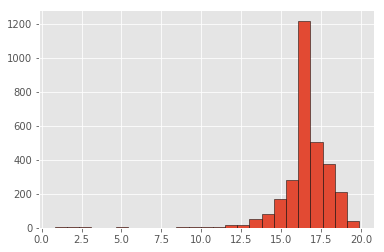

In [84]:
plt.hist(x['inflationBudget_log'], bins=25, edgecolor='black')
plt.show()

### popularity

it doesn't have any missing value but needs to be taken log of

In [85]:
x['popularity_log'] = np.log1p(x['popularity'])
test_data['popularity_log'] = np.log1p(test_data['popularity'])

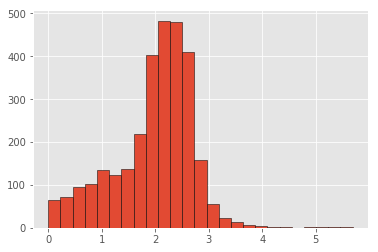

In [86]:
plt.hist(x['popularity_log'], bins=25, edgecolor='black')
plt.show()

In [87]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 97 columns):
id                                        3000 non-null int64
belongs_to_collection                     3000 non-null object
budget                                    3000 non-null int64
genres                                    3000 non-null object
homepage                                  946 non-null object
imdb_id                                   3000 non-null object
original_language                         3000 non-null object
original_title                            3000 non-null object
overview                                  2992 non-null object
popularity                                3000 non-null float64
poster_path                               2999 non-null object
production_companies                      3000 non-null object
production_countries                      3000 non-null object
release_date                              3000 non-null object
runtime      

In [88]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 96 columns):
id                                        4398 non-null int64
belongs_to_collection                     4398 non-null object
budget                                    4398 non-null int64
genres                                    4398 non-null object
homepage                                  1420 non-null object
imdb_id                                   4398 non-null object
original_language                         4398 non-null object
original_title                            4398 non-null object
overview                                  4384 non-null object
popularity                                4398 non-null float64
poster_path                               4397 non-null object
production_companies                      4398 non-null object
production_countries                      4398 non-null object
release_date                              4397 non-null object
runtime     

In [89]:
column_original = list(data_backup.columns) 
column_original

['id',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue']

In [90]:
x_backup = x.copy()
test_data_backup = test_data.copy()

In [91]:
drop_columns = column_original + ['production_countries_substractUS', 'spoken_languages_substractEN', 
                                 'inflationBudget']
drop_columns.remove('runtime')
drop_columns.remove('revenue')
drop_columns

['id',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'production_countries_substractUS',
 'spoken_languages_substractEN',
 'inflationBudget']

In [92]:
x = x.drop(drop_columns, axis=1)
test_data = test_data.drop(drop_columns, axis=1)

In [93]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 73 columns):
runtime                                   2998 non-null float64
belongs_to_collection_cat                 3000 non-null int64
Action                                    3000 non-null int64
Adventure                                 3000 non-null int64
Animation                                 3000 non-null int64
Comedy                                    3000 non-null int64
Crime                                     3000 non-null int64
Documentary                               3000 non-null int64
Drama                                     3000 non-null int64
Family                                    3000 non-null int64
Fantasy                                   3000 non-null int64
Foreign                                   3000 non-null int64
History                                   3000 non-null int64
Horror                                    3000 non-null int64
Music                  

In [94]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 72 columns):
runtime                                   4394 non-null float64
belongs_to_collection_cat                 4398 non-null int64
Action                                    4398 non-null int64
Adventure                                 4398 non-null int64
Animation                                 4398 non-null int64
Comedy                                    4398 non-null int64
Crime                                     4398 non-null int64
Documentary                               4398 non-null int64
Drama                                     4398 non-null int64
Family                                    4398 non-null int64
Fantasy                                   4398 non-null int64
Foreign                                   4398 non-null int64
History                                   4398 non-null int64
Horror                                    4398 non-null int64
Music                  

## Preprocessing


indicate numeric and categorical features

In [95]:
var_num = ['runtime', 'title_word_count', 'tagline_word_count', 'no_cast', 'no_crew', 'genders_0_cast',
 'genders_1_cast',
 'genders_2_cast',
 'genders_0_crew',
 'genders_1_crew',
 'genders_2_crew',
 'inflationBudget_log', 'popularity_log']
var_cat = [col for col in x.columns if col not in var_num]

In [96]:
var_num

['runtime',
 'title_word_count',
 'tagline_word_count',
 'no_cast',
 'no_crew',
 'genders_0_cast',
 'genders_1_cast',
 'genders_2_cast',
 'genders_0_crew',
 'genders_1_crew',
 'genders_2_crew',
 'inflationBudget_log',
 'popularity_log']

In [97]:
var_cat

['belongs_to_collection_cat',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western',
 'homepage_cat',
 'is_origLang_English',
 'is_title_different',
 'other_production_companies',
 'Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation',
 'Columbia Pictures',
 'Metro-Goldwyn-Mayer (MGM)',
 'New Line Cinema',
 'Touchstone Pictures',
 'Walt Disney Pictures',
 'Columbia Pictures Corporation',
 'TriStar Pictures',
 'Relativity Media',
 'Canal+',
 'United Artists',
 'Miramax Films',
 'Village Roadshow Pictures',
 'Regency Enterprises',
 'BBC Films',
 'Working Title Films',
 'Dune Entertainment',
 ' The',
 'Fox Searchlight Pictures',
 'StudioCanal',
 'Lionsgate',
 'DreamWorks SKG',
 'Fox 2000 Pictures',
 'production_US',
 'production_countries_Other',
 'relea

### make dummies for the five date variables

I could use OneHotEncoder but it will be hard to track the names of the newly created features so I will make dummies in this step

In [98]:
for i in var_cat:
    print(i)
    print(x[i].unique())

belongs_to_collection_cat
[1 0]
Action
[0 1]
Adventure
[0 1]
Animation
[0 1]
Comedy
[1 0]
Crime
[0 1]
Documentary
[0 1]
Drama
[0 1]
Family
[0 1]
Fantasy
[0 1]
Foreign
[0 1]
History
[0 1]
Horror
[0 1]
Music
[0 1]
Mystery
[0 1]
Romance
[0 1]
Science Fiction
[0 1]
TV Movie
[0 1]
Thriller
[0 1]
War
[0 1]
Western
[0 1]
homepage_cat
[0 1]
is_origLang_English
[1 0]
is_title_different
[1 0]
other_production_companies
[1 0]
Warner Bros.
[0 1]
Universal Pictures
[0 1]
Paramount Pictures
[1 0]
Twentieth Century Fox Film Corporation
[0 1]
Columbia Pictures
[0 1]
Metro-Goldwyn-Mayer (MGM)
[1 0]
New Line Cinema
[0 1]
Touchstone Pictures
[0 1]
Walt Disney Pictures
[0 1]
Columbia Pictures Corporation
[0 1]
TriStar Pictures
[0 1]
Relativity Media
[0 1]
Canal+
[0 1]
United Artists
[1 0]
Miramax Films
[0 1]
Village Roadshow Pictures
[0 1]
Regency Enterprises
[0 1]
BBC Films
[0 1]
Working Title Films
[0 1]
Dune Entertainment
[0 1]
 The
[0 1]
Fox Searchlight Pictures
[0 1]
StudioCanal
[0 1]
Lionsgate
[0 1]

In [99]:
for col in ['release_month', 'release_day', 'release_year', 'release_dayofweek', 'release_quarter']:
    x = pd.concat([x, pd.get_dummies(x[col],prefix=col)], axis=1)

In [100]:
x.head()

,runtime,belongs_to_collection_cat,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,release_dayofweek_1,release_dayofweek_2,release_dayofweek_3,release_dayofweek_4,release_dayofweek_5,release_dayofweek_6,release_quarter_1,release_quarter_2,release_quarter_3,release_quarter_4
0,93.0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,113.0,1,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,0
2,105.0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,122.0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,118.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [101]:
x.drop(['release_month', 'release_day', 'release_year', 'release_dayofweek', 'release_quarter'], axis=1, inplace=True)

In [102]:
var_cat = [col for col in x.columns if col not in var_num]
var_cat

['belongs_to_collection_cat',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western',
 'homepage_cat',
 'is_origLang_English',
 'is_title_different',
 'other_production_companies',
 'Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation',
 'Columbia Pictures',
 'Metro-Goldwyn-Mayer (MGM)',
 'New Line Cinema',
 'Touchstone Pictures',
 'Walt Disney Pictures',
 'Columbia Pictures Corporation',
 'TriStar Pictures',
 'Relativity Media',
 'Canal+',
 'United Artists',
 'Miramax Films',
 'Village Roadshow Pictures',
 'Regency Enterprises',
 'BBC Films',
 'Working Title Films',
 'Dune Entertainment',
 ' The',
 'Fox Searchlight Pictures',
 'StudioCanal',
 'Lionsgate',
 'DreamWorks SKG',
 'Fox 2000 Pictures',
 'production_US',
 'production_countries_Other',
 'spoke

In [103]:
for i in var_cat:
    print(i)
    print(x[i].unique())

belongs_to_collection_cat
[1 0]
Action
[0 1]
Adventure
[0 1]
Animation
[0 1]
Comedy
[1 0]
Crime
[0 1]
Documentary
[0 1]
Drama
[0 1]
Family
[0 1]
Fantasy
[0 1]
Foreign
[0 1]
History
[0 1]
Horror
[0 1]
Music
[0 1]
Mystery
[0 1]
Romance
[0 1]
Science Fiction
[0 1]
TV Movie
[0 1]
Thriller
[0 1]
War
[0 1]
Western
[0 1]
homepage_cat
[0 1]
is_origLang_English
[1 0]
is_title_different
[1 0]
other_production_companies
[1 0]
Warner Bros.
[0 1]
Universal Pictures
[0 1]
Paramount Pictures
[1 0]
Twentieth Century Fox Film Corporation
[0 1]
Columbia Pictures
[0 1]
Metro-Goldwyn-Mayer (MGM)
[1 0]
New Line Cinema
[0 1]
Touchstone Pictures
[0 1]
Walt Disney Pictures
[0 1]
Columbia Pictures Corporation
[0 1]
TriStar Pictures
[0 1]
Relativity Media
[0 1]
Canal+
[0 1]
United Artists
[1 0]
Miramax Films
[0 1]
Village Roadshow Pictures
[0 1]
Regency Enterprises
[0 1]
BBC Films
[0 1]
Working Title Films
[0 1]
Dune Entertainment
[0 1]
 The
[0 1]
Fox Searchlight Pictures
[0 1]
StudioCanal
[0 1]
Lionsgate
[0 1]

build pipline to pre-process the train data

In [104]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(var_num)),
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(var_cat))
    ])

In [105]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [106]:
x_prepared = full_pipeline.fit_transform(x)
x_prepared.shape

(3000, 212)

take log for revenue

In [107]:
y_log = np.log1p(y)

### Feature Selection

There are too many features, which will tend to overfit the data. I'll pick up the top ones

In [108]:
# split 20% test data with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x_prepared, y_log, test_size=.3, shuffle=True, random_state=42)

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

np.random.seed(42)

Kbest = SelectKBest(f_regression, k=25)
x_train_sel = Kbest.fit_transform(x_train, y_train)

featureScores = Kbest.scores_
feature_selection_df = pd.DataFrame({'feature':x.axes[1], 'F statistic':Kbest.scores_,'p value':Kbest.pvalues_}).sort_values(by='p value').reset_index(
drop=True)
feature_selection_df

,feature,F statistic,p value
0,History,8.179355e+02,3.454708e-152
1,Foreign,7.777670e+02,7.340261e-146
2,Fantasy,4.744564e+02,5.321431e-95
3,Documentary,3.177900e+02,2.660511e-66
4,Animation,2.701779e+02,3.342791e-57
5,Adventure,2.093095e+02,2.729072e-45
6,Family,2.013168e+02,1.058057e-43
7,genders_2_crew,1.978898e+02,5.098081e-43
8,Drama,1.596194e+02,2.558173e-35
9,Horror,1.395995e+02,3.109109e-31


Just select the top 25 features

In [110]:
top_features = list(feature_selection_df.feature[:25])
top_features

['History',
 'Foreign',
 'Fantasy',
 'Documentary',
 'Animation',
 'Adventure',
 'Family',
 'genders_2_crew',
 'Drama',
 'Horror',
 'Crime',
 'runtime',
 'inflationBudget_log',
 'Mystery',
 'Columbia Pictures Corporation',
 'TriStar Pictures',
 'Thriller',
 'Music',
 'is_origLang_English',
 'Canal+',
 'United Artists',
 'Western',
 'War',
 'homepage_cat',
 ' The']

## Modeling

Build a baseline linear regression model

In [111]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [112]:
# to get the RMSE
def RMSE(model, X, y):
    return np.sqrt(np.sum(np.power((model.predict(X) - y), 2))/X.shape[0])

### select top categorical and numeric features

In [113]:
var_cat_top_features = [col for col in var_cat if col in top_features]
var_num_top_features = [col for col in top_features if col not in var_cat_top_features]

In [114]:
var_cat_top_features

['Adventure',
 'Animation',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Thriller',
 'War',
 'Western',
 'homepage_cat',
 'is_origLang_English',
 'Columbia Pictures Corporation',
 'TriStar Pictures',
 'Canal+',
 'United Artists',
 ' The']

In [115]:
var_num_top_features

['genders_2_crew', 'runtime', 'inflationBudget_log']

In [116]:
num_pipeline_top_features = Pipeline([
        ('selector', DataFrameSelector(var_num_top_features)),
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline_top_features = Pipeline([
        ('selector', DataFrameSelector(var_cat_top_features))
    ])

full_pipeline_top_features = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline_top_features),
        ("cat_pipeline", cat_pipeline_top_features),
    ])

In [117]:
x_prepared_top_features = full_pipeline_top_features.fit_transform(x[top_features])
x_prepared_top_features.shape

(3000, 25)

### create a baseline model using ordinary linear regression

In [118]:
# re-split 20% test data with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x_prepared_top_features, 
                                                    y_log, test_size=.3, shuffle=True, random_state=42)

start = time()
np.random.seed(42)

linearRegression = LinearRegression()
linearRegression.fit(x_train, y_train)
linear_scores = cross_val_score(linearRegression, x_train,
                               y_train, scoring='neg_mean_squared_error', cv=5)
linear_score_train = np.sqrt(-linear_scores.mean())
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
linear_score_test  = RMSE(linearRegression, x_test, y_test)
test_time = np.round(time() - start, 4)

In [119]:
results_tmdb = pd.DataFrame(columns=["ExpID", "Cross fold train RMSE", "Test RMSE", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

results_tmdb.loc[0] = ["Baseline", linear_score_train, linear_score_test, 
                  "---", train_time, test_time, "Untuned LinearRegression"]
results_tmdb

,ExpID,Cross fold train RMSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,2.421763,2.314993,---,0.0369,0.001,Untuned LinearRegression


### grand search using different models

modify the ConductGridSearch() for linear regression. 
<br>
**I've completed the feature engineering and selection process in the previous steps so I won't be using any data_preparation pipelines here.**

In [120]:
# A Function to execute the grid search and record the results.
def ConductGridSearch_ContinuousY(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    regressors = [
        ('Ridge', Ridge(random_state=42)),
        ('Lasso', Lasso(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsRegressor()),
        ('Support Vector', SVR()),
        ('Stochastic GD', SGDRegressor(random_state=42)),
        ('RandomForest', RandomForestRegressor(random_state=42))
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Ridge': {
            'alpha': (.001, .01, .1, .1, 10, 100),
        },
        'Lasso': {
            'alpha': (.001, .01, .1, .1, 10, 100),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, regressor) in regressors:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_RMSE = RMSE(grid_search.best_estimator_, X_test, y_test)
        test_time = round(time() - start, 4)

        # Generate 5 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, 
                                           scoring='neg_mean_squared_error', cv=5)
        best_train_RMSE = np.sqrt(-best_train_scores.mean())        
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(linear_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
#             import pdb; pdb.set_trace()
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results_tmdb.loc[i] = [prefix+name, best_train_RMSE, best_test_RMSE, round(p_value,5),
                          train_time, test_time, json.dumps(param_dump)]

In [121]:
%%time
ConductGridSearch_ContinuousY(x_train, y_train, x_test, y_test, 0, "Best Model:")

****** START Best Model: Ridge *****
Parameters:
	alpha: (0.001, 0.01, 0.1, 0.1, 10, 100)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters:
	alpha: 10
****** FINISH Best Model: Ridge  *****

****** START Best Model: Lasso *****
Parameters:
	alpha: (0.001, 0.01, 0.1, 0.1, 10, 100)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


Best Parameters:
	alpha: 0.001
****** FINISH Best Model: Lasso  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.9s finished


Best Parameters:
	n_neighbors: 11
	p: 1
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   46.6s finished


Best Parameters:
	C: 10
	degree: 1
	kernel: rbf
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.2s finished


Best Parameters:
	alpha: 0.001
	penalty: l1
	tol: 1e-07
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed:  9.9min finished


Best Parameters:
	bootstrap: False
	max_depth: 15
	max_features: 5
	min_samples_leaf: 3
	min_samples_split: 5
	n_estimators: 80
****** FINISH Best Model: RandomForest  *****

Wall time: 10min 54s


## Evaluation, reporting and analysis


In [122]:
results_tmdb

,ExpID,Cross fold train RMSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,2.421763,2.314993,---,0.0369,0.0010,Untuned LinearRegression
1,Best Model:Ridge,2.421094,2.303039,0.90216,0.0010,0.0010,"[[""alpha"", 10]]"
2,Best Model:Lasso,2.421553,2.310306,0.78112,0.0010,0.0010,"[[""alpha"", 0.001]]"
3,Best Model:K-Nearest Neighbors,2.432425,2.290514,0.67517,0.0030,0.0439,"[[""n_neighbors"", 11], [""p"", 1]]"
4,Best Model:Support Vector,2.403202,2.207356,0.53928,0.2649,0.0625,"[[""C"", 10], [""degree"", 1], [""kernel"", ""rbf""]]"
5,Best Model:Stochastic GD,2.423727,2.302084,0.78792,0.0312,0.0000,"[[""alpha"", 0.001], [""penalty"", ""l1""], [""tol"", ..."
6,Best Model:RandomForest,2.322507,2.207361,0.1395,0.1538,0.0157,"[[""bootstrap"", false], [""max_depth"", 15], [""ma..."


The random forest appears to be the winner, although the p_value is high. It may be that we only have 5-fold cross-validation.

Let's try xgboost.

In [124]:
import xgboost as xgb

xgbmodel = xgb.XGBRegressor(max_depth=6, 
                            learning_rate=0.01, 
                            objective='reg:linear', 
                            seed=42, 
                            silent=True,
                            subsample=0.9, 
                            colsample_bytree=0.7, 
                            colsample_bylevel=0.5)

#fitting time
start = time()
xgbmodel.fit(x_train, y_train)
train_time = round(time() - start, 4)

#prediction time
start = time()
xgb_test_RMSE = RMSE(xgbmodel, x_test, y_test)
test_time = round(time() - start, 4)

# Generate 5 training MSE scores with 5-split CV
xgb_train_scores = cross_val_score(xgbmodel, x_train, y_train, cv=5)
xgb_train_RMSE = np.sqrt(-xgb_train_scores.mean()) 

(t_stat, p_value) = stats.ttest_rel(linear_scores,xgb_train_scores)

results_tmdb = results_tmdb.append(pd.DataFrame([('XGBoost', xgb_train_RMSE, xgb_test_RMSE, round(p_value,5),
                  train_time, test_time, 'Untuned XGBoost')], columns=["ExpID", "Cross fold train RMSE", 
                    "Test RMSE", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"]))

In [125]:
results_tmdb

,ExpID,Cross fold train RMSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,2.421763,2.314993,---,0.0369,0.0010,Untuned LinearRegression
1,Best Model:Ridge,2.421094,2.303039,0.90216,0.0010,0.0010,"[[""alpha"", 10]]"
2,Best Model:Lasso,2.421553,2.310306,0.78112,0.0010,0.0010,"[[""alpha"", 0.001]]"
3,Best Model:K-Nearest Neighbors,2.432425,2.290514,0.67517,0.0030,0.0439,"[[""n_neighbors"", 11], [""p"", 1]]"
4,Best Model:Support Vector,2.403202,2.207356,0.53928,0.2649,0.0625,"[[""C"", 10], [""degree"", 1], [""kernel"", ""rbf""]]"
5,Best Model:Stochastic GD,2.423727,2.302084,0.78792,0.0312,0.0000,"[[""alpha"", 0.001], [""penalty"", ""l1""], [""tol"", ..."
6,Best Model:RandomForest,2.322507,2.207361,0.1395,0.1538,0.0157,"[[""bootstrap"", false], [""max_depth"", 15], [""ma..."
0,XGBoost,1.751214,6.245148,0.03259,1.0845,0.0060,Untuned XGBoost


hmm...something is wrong with the way I did with xgboost.. will explore more later when I have time..

## Kaggle Submission


Let's just choose the RandomForrest mdoel with the best hyperparameters as out final model.

transform the test data set

In [126]:
test_data_prepared_top_features = full_pipeline_top_features.transform(test_data[top_features])
test_data_prepared_top_features.shape

(4398, 25)

In [127]:
model_tmdb_rf = RandomForestRegressor(bootstrap=False,
    max_depth=15,
    max_features=5,
    min_samples_leaf=3,
    min_samples_split=5,
    n_estimators=80, random_state=42)

model_tmdb_rf.fit(x_train, y_train)
pred = model_tmdb_rf.predict(test_data_prepared_top_features)
test_data['revenue'] = np.expm1(pred)

#get the original id
test_data_ = pd.read_csv('datasets/TMDB/test.csv')
test_data['id'] = test_data_['id']

test_data[['id', 'revenue']].to_csv('submission.csv')

In [128]:
test_data[['id', 'revenue']].head()

,id,revenue
0,3001,1.106198e+07
1,3002,3.840873e+06
2,3003,1.215949e+06
3,3004,9.499903e+06
4,3005,3.029637e+06
